In [ ]:
import ee
import pandas as pd
import time
from datetime import datetime, timedelta
import os


# Initialize Earth Engine with Project ID
Project_id = 'ee-deepeshy'
try:
    ee.Initialize(project=Project_id)
    print("Earth Engine Initialised Successfully!")
except ee.EEException:
    print("Authentication required. Please follow the instructions.")
    ee.Authenticate()
    ee.Initialize(project=Project_id)

# Define Sundarbans region (simplified bounding box)
sundarbans_geo = ee.Geometry.Rectangle([88.0, 21.5, 89.5, 22.2])

# Output directory
output_dir = r'C:\Users\dhani\OneDrive\Desktop\satelite_image\project\csv'
os.makedirs(output_dir, exist_ok=True)

def collect_sentinel2_mangrove_data():
    """
    Collect mangrove data using Sentinel-2 imagery for selected dates
    """
    print("\n==== COLLECTING MANGROVE DATA WITH SENTINEL-2 ====")

    # Define factors for carbon calculations
    carbon_density = 447  # tC/ha
    sequestration_rate = 10  # tonnes CO2/ha/yr


    start_date = datetime(2019, 1, 1)
    end_date = datetime(2022, 12, 31)
    delta = timedelta(days=7)

    test_dates = []
    current_date = start_date

    while current_date <= end_date:
        test_dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += delta

    # Container for results
    results = []

    for base_date in test_dates:
        # Use a 15-day window to find imagery
        start_date = base_date

        # Calculate end date (15 days after start)
        base_dt = datetime.strptime(base_date, '%Y-%m-%d')
        end_dt = base_dt + timedelta(days=15)
        end_date = end_dt.strftime('%Y-%m-%d')

        print(f"\nProcessing period {start_date} to {end_date}...")

        try:
            # Get Sentinel-2 collection for this date range
            sentinel_collection = ee.ImageCollection("COPERNICUS/S2_SR") \
                .filterDate(start_date, end_date) \
                .filterBounds(sundarbans_geo) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)) \
                .sort('CLOUDY_PIXEL_PERCENTAGE')

            # Check if we have images
            collection_size = sentinel_collection.size().getInfo()
            print(f"  Found {collection_size} Sentinel-2 images")

            if collection_size == 0:
                print(f"  No clear Sentinel-2 images available for {base_date}")
                continue

            # Create a median composite to reduce cloud influence
            composite = sentinel_collection.median()

            # Calculate indices
            # Scale the bands (Sentinel-2 data needs to be divided by 10000)
            scaled_img = composite.divide(10000)

            # NDVI = (NIR - Red) / (NIR + Red) - using bands B8 and B4
            ndvi = scaled_img.normalizedDifference(['B8', 'B4']).rename('NDVI')

            # NDWI = (Green - NIR) / (Green + NIR) - using bands B3 and B8
            ndwi = scaled_img.normalizedDifference(['B3', 'B8']).rename('NDWI')

            # EVI = 2.5 * ((NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1))
            evi = scaled_img.expression(
                '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
                    'NIR': scaled_img.select('B8'),
                    'RED': scaled_img.select('B4'),
                    'BLUE': scaled_img.select('B2')
                }
            ).rename('EVI')

            # Identify potential mangrove areas
            # Mangroves typically have high NDVI and low/negative NDWI
            mangrove_mask = ndvi.gt(0.3)  # NDVI > 0.3 for vegetation

            # Calculate area
            pixel_area = ee.Image.pixelArea().divide(10000)  # m² → ha
            mangrove_area_img = mangrove_mask.multiply(pixel_area)

            # Sum the area
            mangrove_area_sum = mangrove_area_img.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=sundarbans_geo,
                scale=30,
                maxPixels=1e12
            ).getInfo()

            # Extract the area value
            mangrove_area_ha = mangrove_area_sum.get('NDVI')

            if mangrove_area_ha is None:
                print(f"  Could not calculate area. Available keys: {list(mangrove_area_sum.keys())}")
                continue

            # Calculate carbon metrics
            carbon_stock = mangrove_area_ha * carbon_density
            co2_absorption = mangrove_area_ha * sequestration_rate

            # Get mean indices for mangrove areas
            indices = ee.Image.cat([ndvi, ndwi, evi]).updateMask(mangrove_mask)
            indices_stats = indices.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=sundarbans_geo,
                scale=30,
                maxPixels=1e12
            ).getInfo()

            # Get the values
            mean_ndvi = indices_stats.get('NDVI')
            mean_ndwi = indices_stats.get('NDWI')
            mean_evi = indices_stats.get('EVI')

            # Add to results
            year = int(base_date.split('-')[0])
            results.append({
                'date': base_date,
                'year': year,
                'NDVI': mean_ndvi,
                'NDWI': mean_ndwi,
                'EVI': mean_evi,
                'total_mangrove_area_ha': mangrove_area_ha,
                'total_carbon_stock_tonnes': carbon_stock,
                'total_CO2_absorption_tonnes_per_year': co2_absorption
            })

            print(f"  Successfully processed period around {base_date}")
            print(f"  Mangrove area: {mangrove_area_ha:.2f} ha")
            print(f"  Mean NDVI: {mean_ndvi:.4f}")
            print(f"  Mean EVI: {mean_evi:.4f}")

        except Exception as e:
            print(f"  Error processing {base_date}: {str(e)}")

    # Create DataFrame
    if results:
        df = pd.DataFrame(results)

        # Save to CSV
        csv_path = os.path.join(output_dir, 'mangrove_metrics_summary.csv')
        df.to_csv(csv_path, index=False)
        print(f"\nSaved mangrove data to {csv_path}")

        return df
    else:
        print("No data collected.")
        return None

# Run the collection function
mangrove_df = collect_sentinel2_mangrove_data()

# Display the results if available
if mangrove_df is not None:
    print("\nCollected Mangrove Data:")
    print(mangrove_df)

Authentication required. Please follow the instructions.

==== COLLECTING MANGROVE DATA WITH SENTINEL-2 ====

Processing period 2019-01-01 to 2019-01-16...


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


  Found 28 Sentinel-2 images
  Successfully processed period around 2019-01-01
  Mangrove area: 473184.74 ha
  Mean NDVI: 0.5841
  Mean EVI: 0.3852

Processing period 2019-01-08 to 2019-01-23...
  Found 28 Sentinel-2 images
  Successfully processed period around 2019-01-08
  Mangrove area: 466912.13 ha
  Mean NDVI: 0.5369
  Mean EVI: 0.3811

Processing period 2019-01-15 to 2019-01-30...
  Found 28 Sentinel-2 images
  Successfully processed period around 2019-01-15
  Mangrove area: 476242.54 ha
  Mean NDVI: 0.5450
  Mean EVI: 0.3679

Processing period 2019-01-22 to 2019-02-06...
  Found 30 Sentinel-2 images
  Successfully processed period around 2019-01-22
  Mangrove area: 564072.25 ha
  Mean NDVI: 0.6468
  Mean EVI: 0.3382

Processing period 2019-01-29 to 2019-02-13...
  Found 29 Sentinel-2 images
  Successfully processed period around 2019-01-29
  Mangrove area: 558830.67 ha
  Mean NDVI: 0.6393
  Mean EVI: 0.3406

Processing period 2019-02-05 to 2019-02-20...
  Found 25 Sentinel-2 ima

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Performance Metrics for Random Forest:
MAE: 30056795.6449
RMSE: 51774802.9475
R² Score: 0.2456

Performance Metrics for SARIMA:
MAE: 17531306.1997
RMSE: 34661381.8742
R² Score: 0.6619


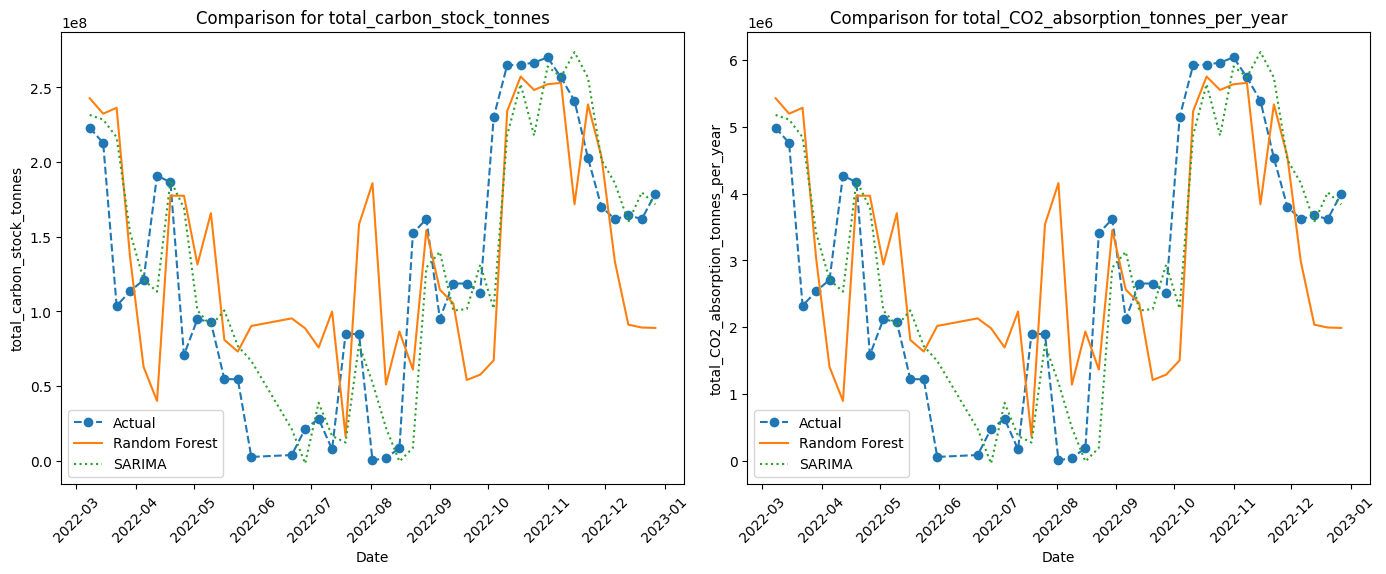

Models saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset
file_path = "/content/sample_data/mangrove_metrics_summary.csv"  # Change to your CSV file path
df = pd.read_csv(file_path)

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the date as index (for time series modeling)
df.set_index('date', inplace=True)

# Selecting target variables
target_cols = ['total_carbon_stock_tonnes', 'total_CO2_absorption_tonnes_per_year']

# Creating lag features for each target variable
for target in target_cols:
    df[f'{target}_lag1'] = df[target].shift(1)
    df[f'{target}_lag2'] = df[target].shift(2)

# Drop rows with NaN values (due to shifting)
df.dropna(inplace=True)

# Selecting feature columns (lag values)
feature_cols = [f'{col}_lag1' for col in target_cols] + [f'{col}_lag2' for col in target_cols]

# Define X (features) and y (targets)
X = df[feature_cols]
y = df[target_cols]

# Splitting data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ------------------ Random Forest Model ------------------

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save Random Forest Model
joblib.dump(rf_model, 'random_forest_model.pkl')

# Predicting on test data
rf_preds = rf_model.predict(X_test)
rf_preds_df = pd.DataFrame(rf_preds, index=y_test.index, columns=target_cols)

# ------------------ SARIMA Model ------------------

sarima_preds = {}
sarima_models = {}

for target in target_cols:
    # Fit SARIMA model
    sarima_model = SARIMAX(df[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False)

    # Save SARIMA model
    with open(f'sarima_model_{target}.pkl', 'wb') as f:
        pickle.dump(sarima_result, f)

    # Forecast on the test set
    sarima_preds[target] = sarima_result.predict(start=y_test.index[0], end=y_test.index[-1])
    sarima_models[target] = sarima_result

# Convert SARIMA predictions to DataFrame
sarima_preds_df = pd.DataFrame(sarima_preds, index=y_test.index)

# ------------------ Performance Metrics ------------------

def evaluate_model(y_true, y_pred, model_name):
    print(f"\nPerformance Metrics for {model_name}:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")

# Evaluate models
evaluate_model(y_test, rf_preds_df, "Random Forest")
evaluate_model(y_test, sarima_preds_df, "SARIMA")

# ------------------ Plot Comparison Graphs ------------------

plt.figure(figsize=(14, 6))

for i, target in enumerate(target_cols):
    plt.subplot(1, 2, i + 1)
    plt.plot(y_test.index, y_test[target], label='Actual', marker='o', linestyle='dashed')
    plt.plot(y_test.index, rf_preds_df[target], label='Random Forest', linestyle='solid')
    plt.plot(y_test.index, sarima_preds_df[target], label='SARIMA', linestyle='dotted')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Comparison for {target}')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Models saved successfully!")

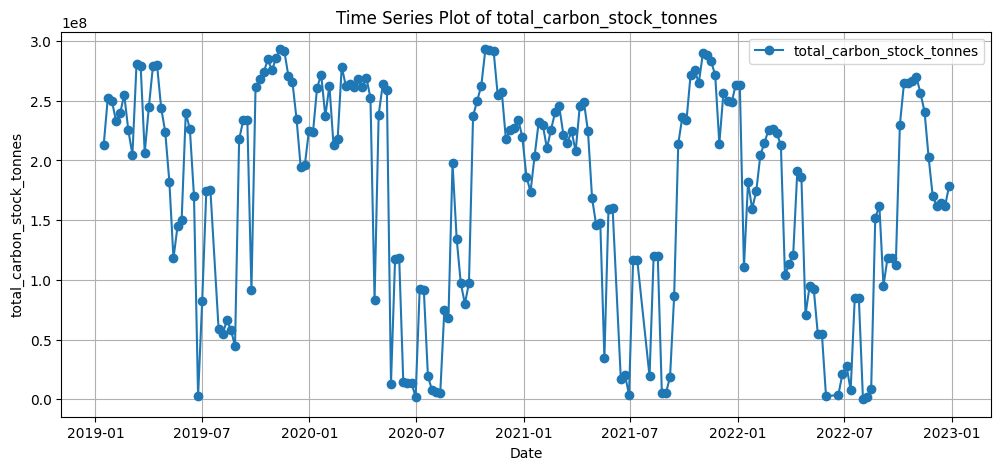

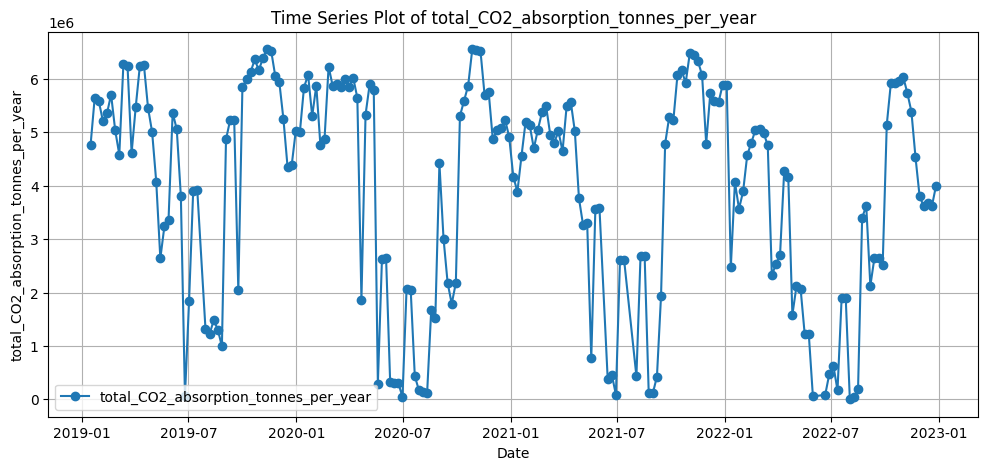

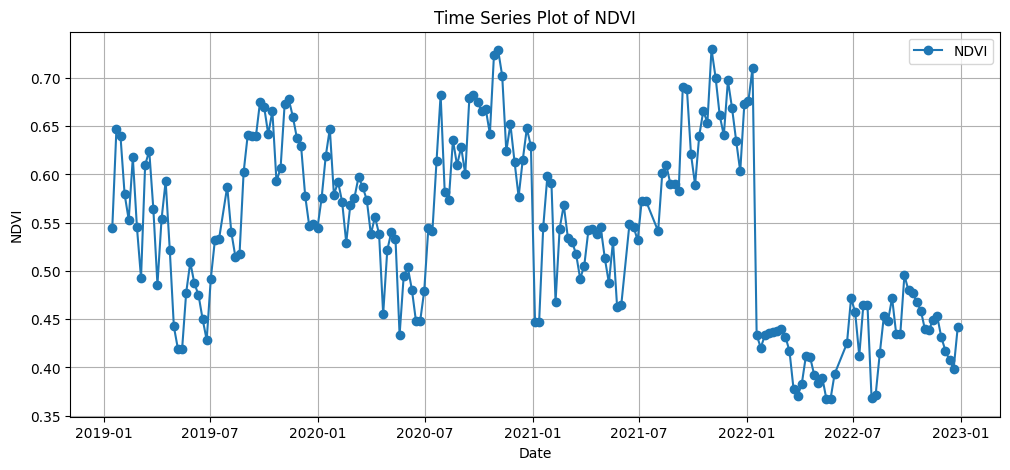

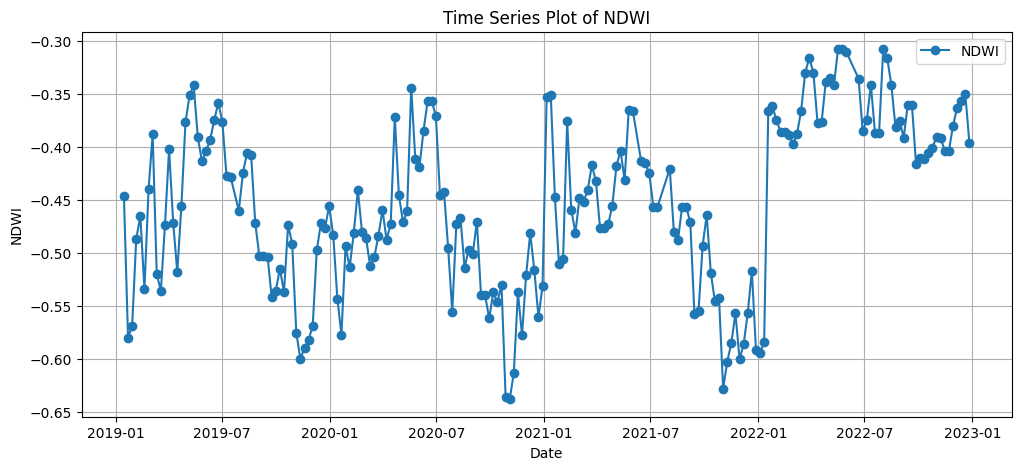

In [ ]:
# Time-series plot of target variables
for col in ['total_carbon_stock_tonnes', 'total_CO2_absorption_tonnes_per_year', 'NDVI', 'NDWI']:
    if col in df.columns:
        plt.figure(figsize=(12, 5))
        plt.plot(df.index, df[col], label=col, marker='o')
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Time Series Plot of {col}')
        plt.legend()
        plt.grid()
        plt.show()